# Weather Forecasting Time Series - Data Analysis

## Project Overview
This notebook provides comprehensive exploratory data analysis (EDA) of weather data for time series forecasting. Building on the initial data overview, we'll deep dive into patterns, relationships, and feature engineering.

## Objectives
1. **Feature Engineering**: Create temporal and aggregated features for modeling
2. **Correlation Analysis**: Understand relationships between weather variables
3. **Temporal Pattern Analysis**: Visualize patterns across different time dimensions
4. **Advanced Visualizations**: Create detailed plots to understand weather dynamics
5. **Weather Type Analysis**: Analyze different weather conditions and patterns

---

## 1. Library Imports and Setup

Import all necessary libraries for advanced data analysis and visualization.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')
import sys
import os
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), '..'))
import src.data.utils as utils

## 2. Data Loading and Preparation

Load and prepare the weather dataset for analysis.

In [2]:
path = '../../data/raw/'

# Load data
raw = utils._load_data(path, 'weather_data.csv')
cols_description = utils._load_data(path, 'column_descriptions.csv')

# Prepare data
raw = utils._prepare_data(raw, 'date')
print(f"Dataset shape: {raw.shape}")
print(f"Date range: {raw.index.min()} to {raw.index.max()}")

Dataset shape: (52696, 23)
Date range: 2020-01-01 00:10:00 to 2021-01-01 00:00:00


## 3. Correlation Analysis

Analyze relationships between weather variables through correlation analysis.

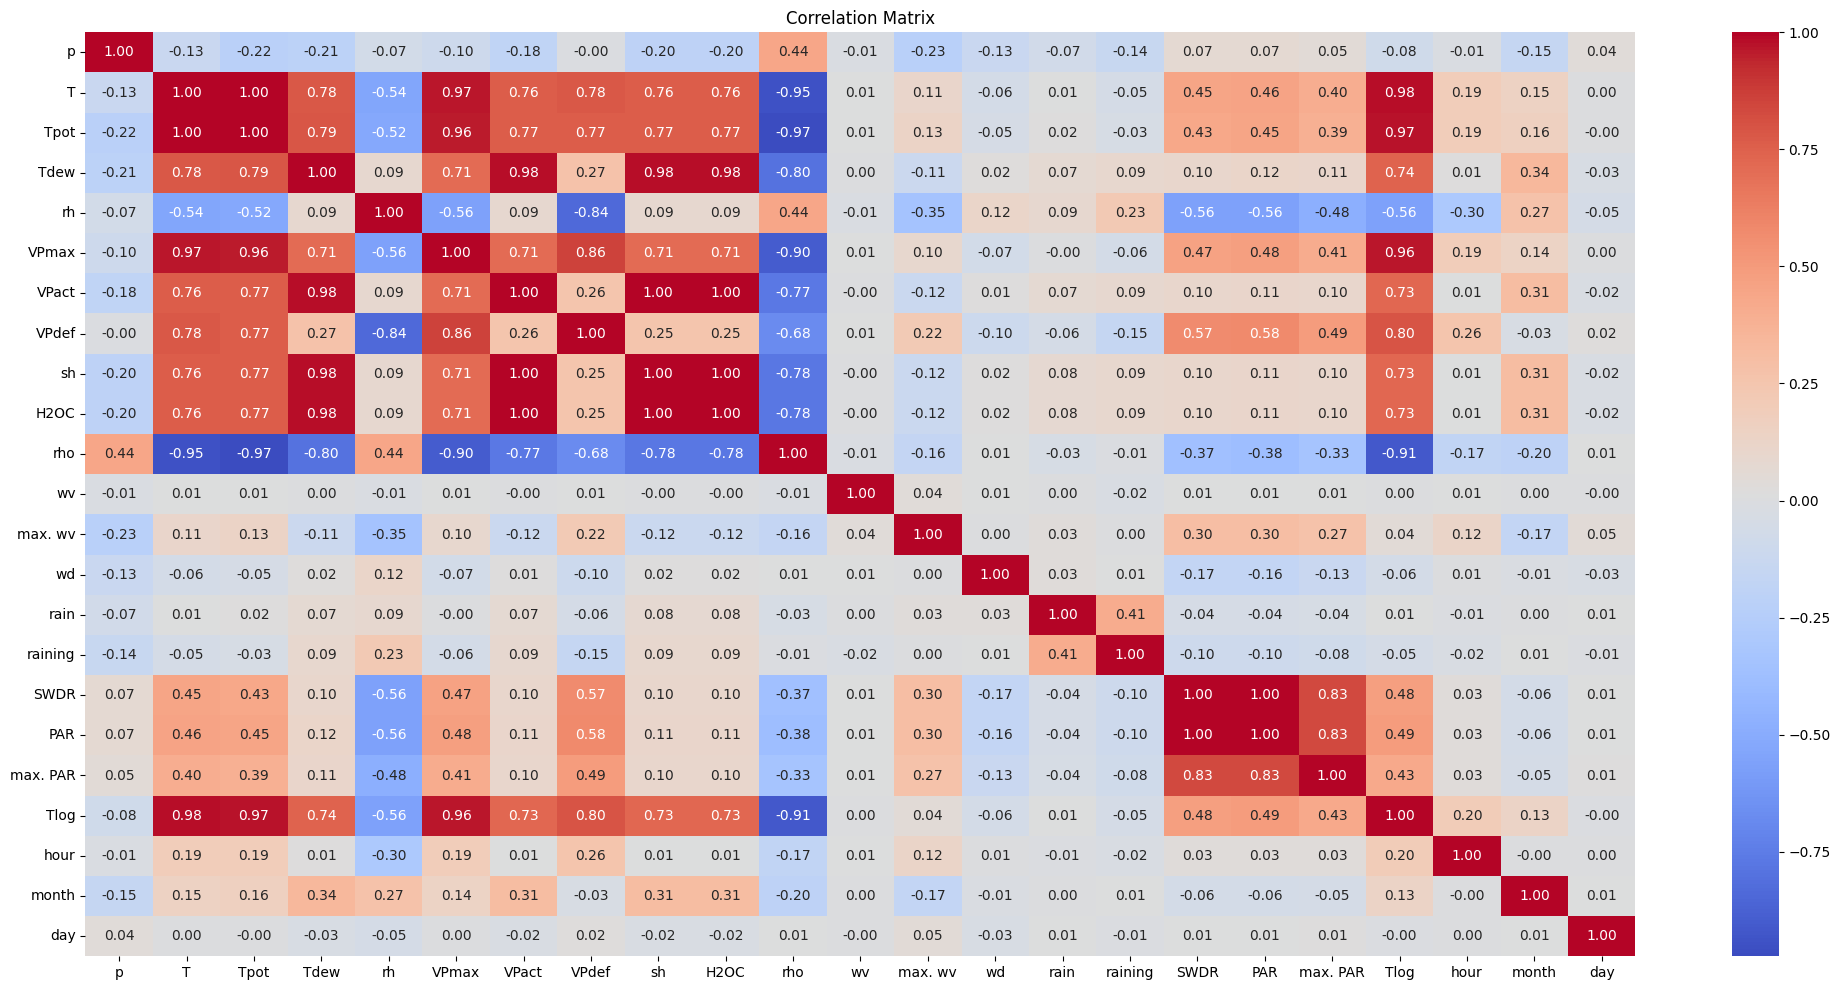

In [3]:
describe, correlations = utils._basic_statistics(raw)
utils._plot_correlation_matrix(correlations)

## 4. Feature Engineering

Create additional features that may be valuable for time series forecasting.

### 4.1 Daily Aggregated Features and Cyclical Time Features

In [4]:
# Create daily aggregated features
raw = utils._daily_columns(raw)

# Create cyclical time features
raw = utils._coordinate_hourly_monthly_data(raw)

print(f"New features added. Dataset now has {raw.shape[1]} columns.")

New features added. Dataset now has 36 columns.


### 4.2 Daily Statistics Summary

Examine the daily aggregated statistics for key weather variables:

In [5]:
daily_summary = raw.resample('D').mean().describe()[['rain_total', 'T_mean', 'T_min', 'T_max', 'rh_mean', 'wv']]
display(daily_summary)

,rain_total,T_mean,T_min,T_max,rh_mean,wv
count,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000
mean,1.690463,10.794832,6.159019,15.307439,72.510647,1.992138
std,5.383870,6.718604,6.016605,7.870443,13.978555,3.701414
min,0.000000,-2.705417,-6.440000,-0.120000,43.658750,-65.882431
25%,0.000000,4.836076,1.340000,8.815000,61.169688,1.452118
50%,0.000000,10.582153,5.650000,15.040000,72.993194,1.879653
75%,0.800000,16.074028,10.735000,21.690000,83.360451,2.685799
max,46.400000,26.869375,19.250000,34.800000,100.000000,6.453403


### 4.3 Wind Analysis

Convert wind direction to categorical features and create wind speed categories:

In [6]:
raw = utils._wind_directions_to_cartesian(raw, "wd")

# Show wind speed and direction categories
print("Wind Speed Categories:")
print(raw['speed_cat'].value_counts())
print("\nWind Direction Categories:")
print(raw['dir_cat'].value_counts())

Wind Speed Categories:
speed_cat
0-2     29664
2-4     16238
4-6      5094
6-8      1419
8-10      218
>10        62
Name: count, dtype: int64

Wind Direction Categories:
dir_cat
SSW    9928
S      8607
SW     5194
SSE    5124
WSW    4515
NNE    4223
SE     2764
NE     2593
N      2217
W      1415
ESE    1347
ENE    1319
NNW    1050
E       981
WNW     718
NW      700
Name: count, dtype: int64


### 4.4 Delta Features

Create features that capture changes and differences in weather variables:

In [7]:
raw = utils._delta_features(raw)
print("Delta features created:")
print("- T_delta_dew: Temperature difference from dew point")
print("- p_delta: Pressure change over 5 hours")

Delta features created:
- T_delta_dew: Temperature difference from dew point
- p_delta: Pressure change over 5 hours


## 5. Temporal Pattern Analysis

Visualize how weather variables change over time and identify patterns.

### 5.1 Time Series Visualization

Plot key weather variables over a short time period to see daily patterns:

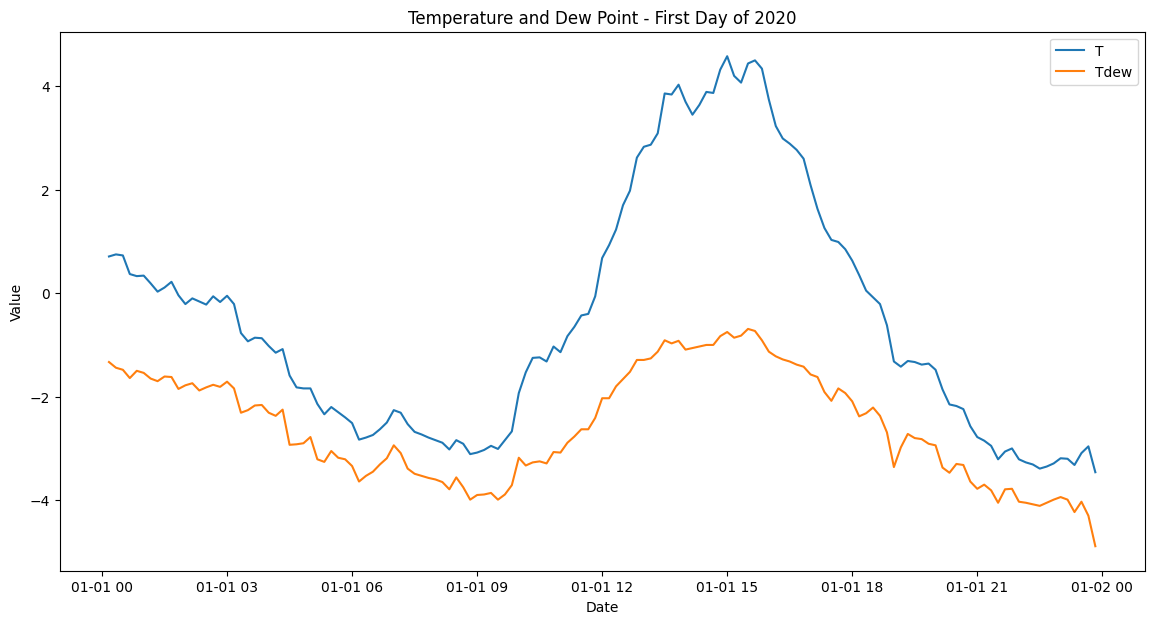

In [8]:
# Plot temperature and dew point for first few days
utils._plot_time_series(
    raw.loc[raw.index < pd.to_datetime("2020-01-02")], 
    ["T", "Tdew"], 
    "Temperature and Dew Point - First Day of 2020"
)

### 5.2 Weather Pattern Analysis by Time Dimensions

Analyze how different weather variables vary across months, hours, and days for the year 2020:

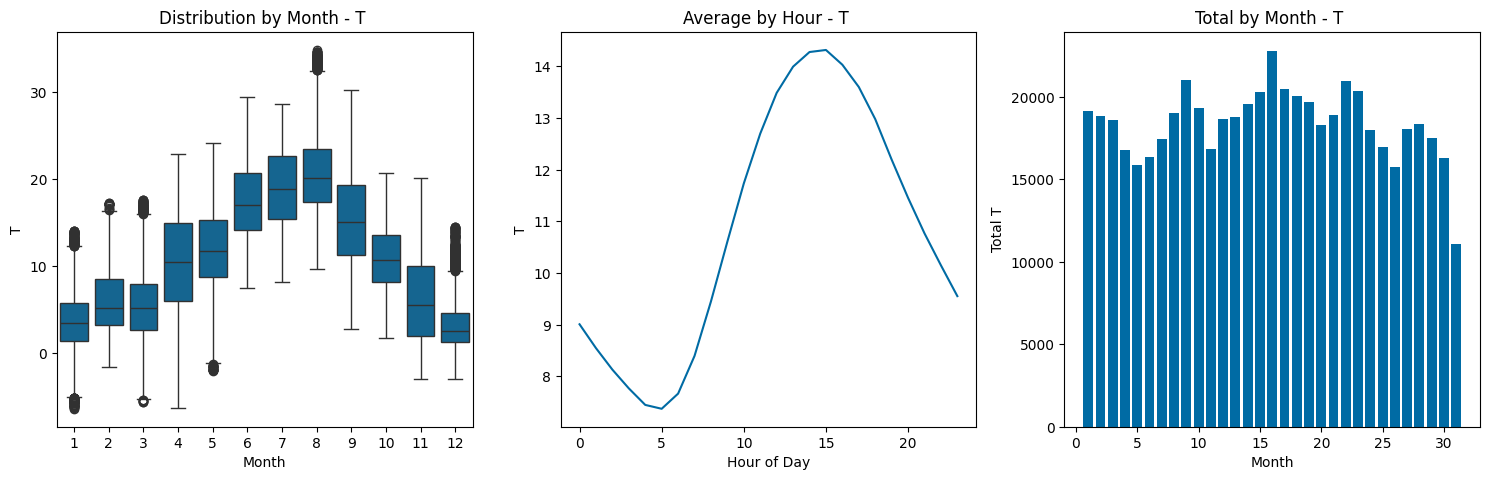

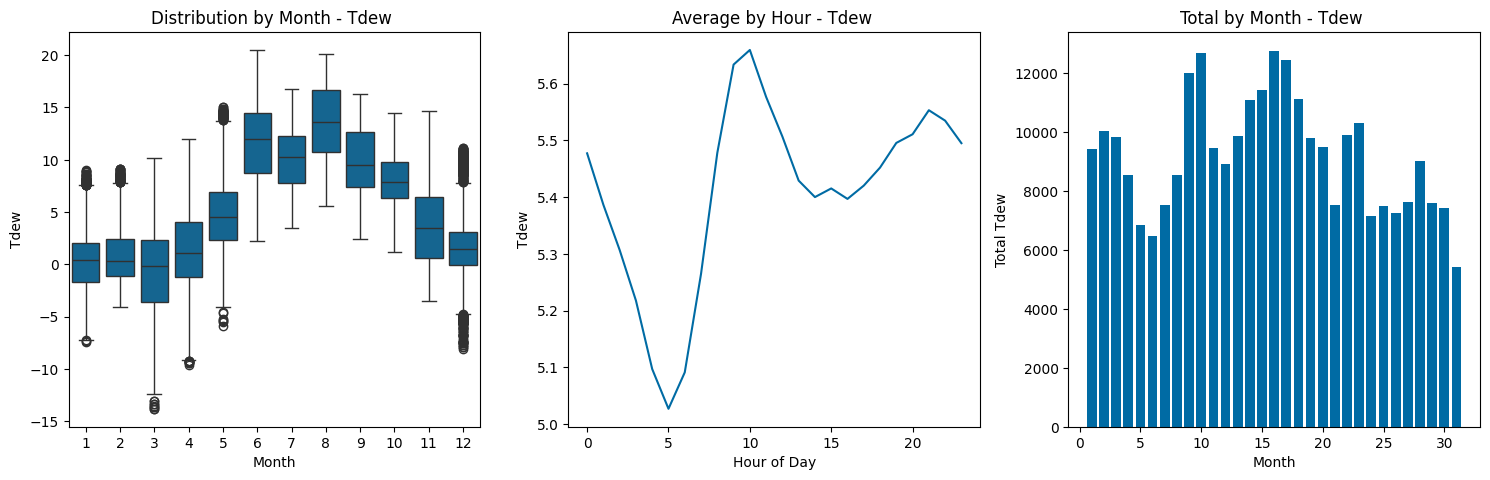

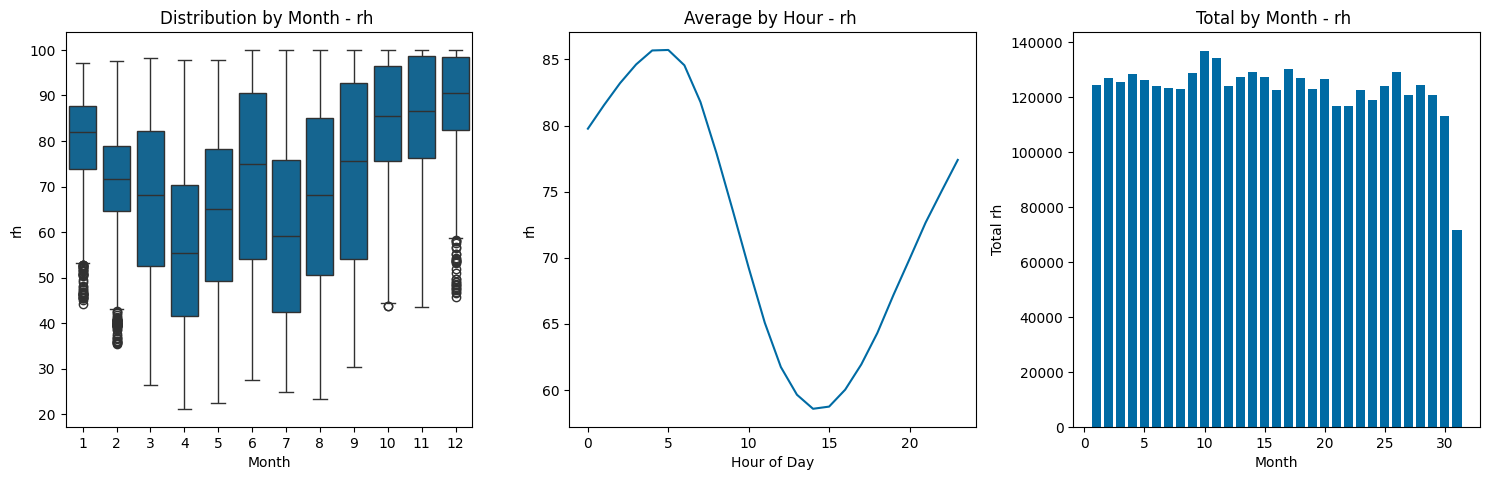

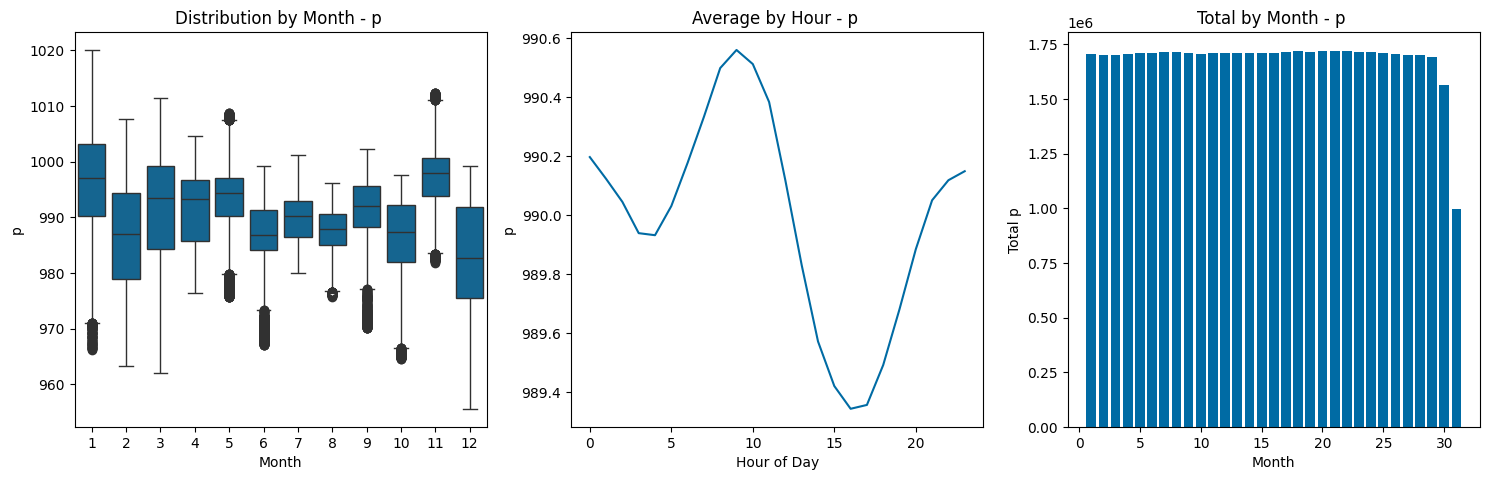

In [9]:
plt.style.use("tableau-colorblind10")

# Analyze patterns for 2020 data
data_2020 = raw.loc[raw.index.year == 2020]

# Temperature patterns
utils._plot_weather_patterns(data_2020, "T")

# Dew point patterns
utils._plot_weather_patterns(data_2020, "Tdew")

# Relative humidity patterns
utils._plot_weather_patterns(data_2020, "rh")

# Pressure patterns
utils._plot_weather_patterns(data_2020, "p")

## 6. Weather Variable Relationships

Analyze relationships between different weather variables using box plots.

### 6.1 Temperature vs Wind Speed Categories

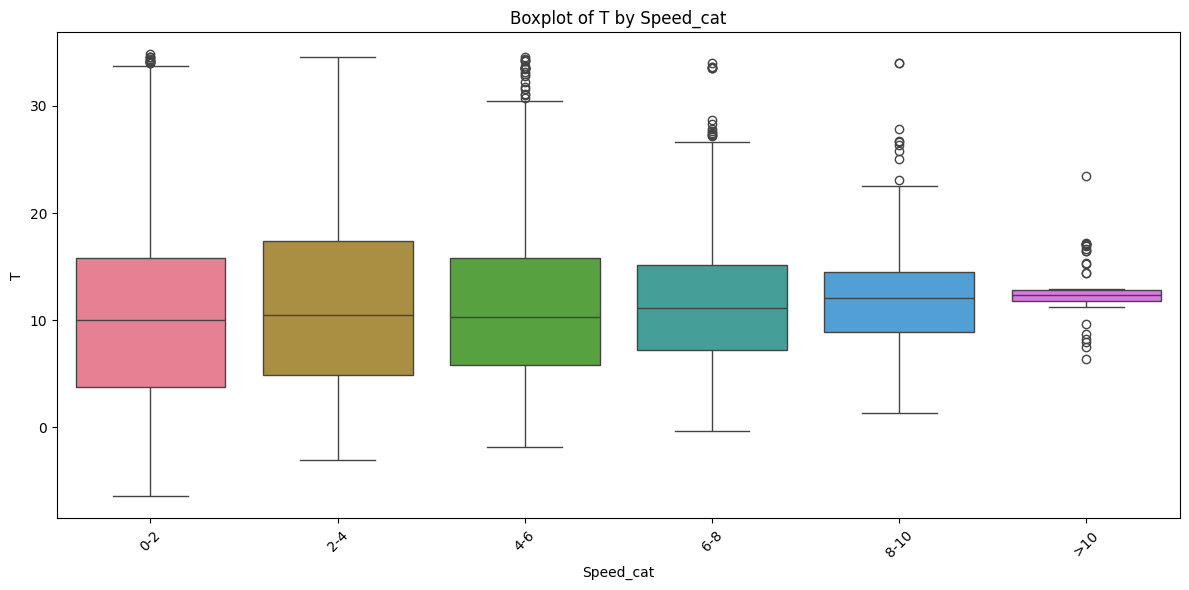

In [10]:
utils._plot_boxplot(raw, "T", "speed_cat")

### 6.2 Weather Variables on Rainy vs Non-Rainy Days

Compare different weather conditions between rainy and non-rainy days:

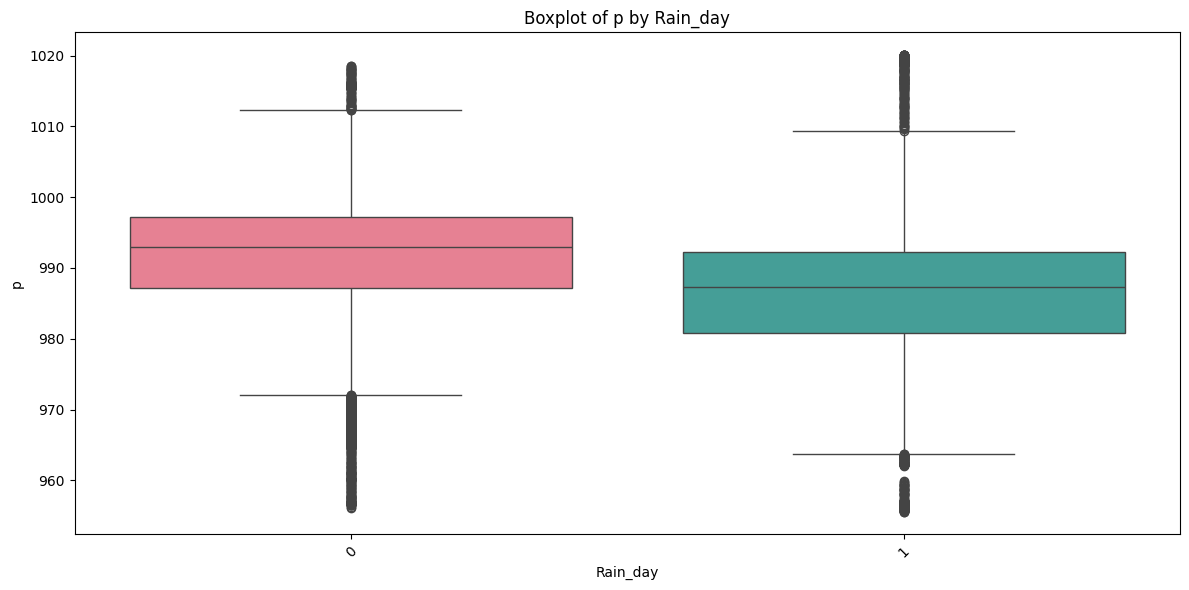

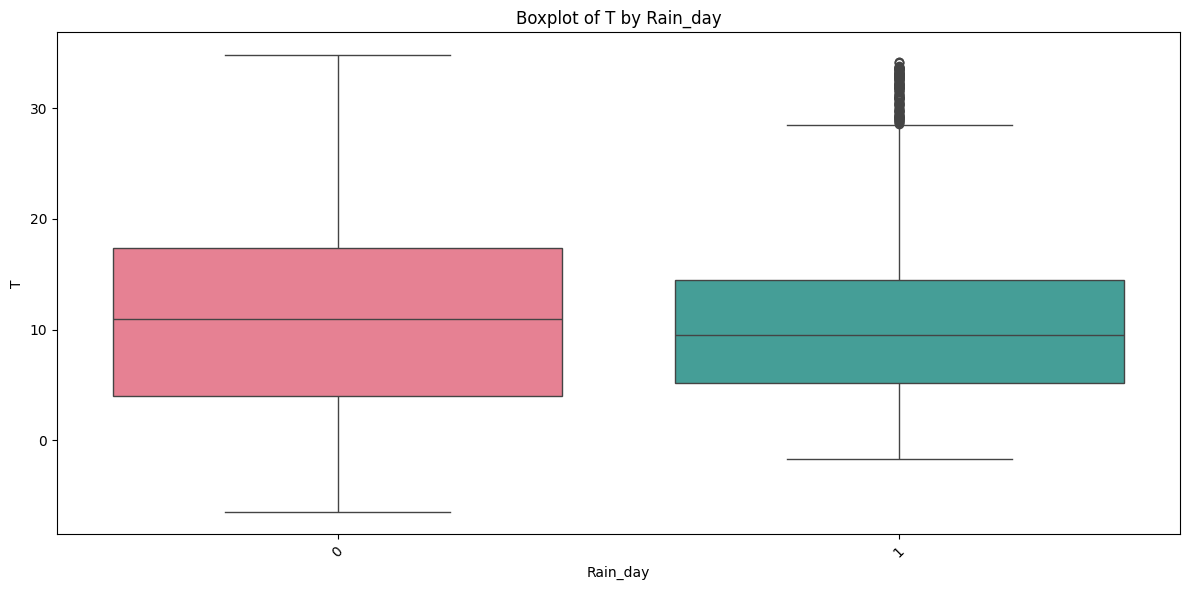

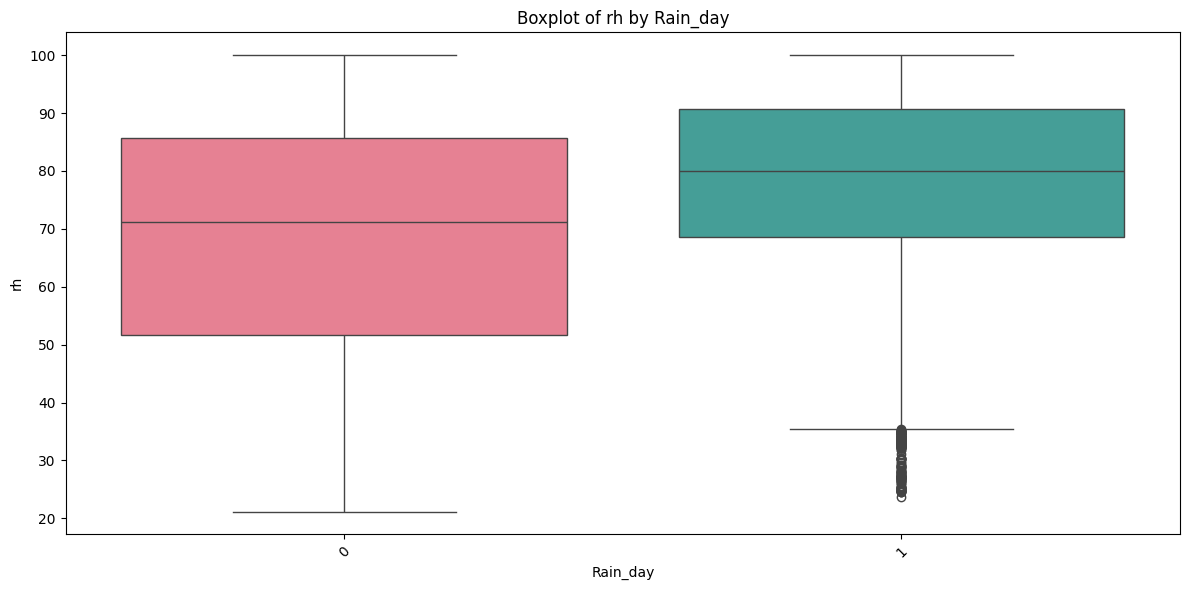

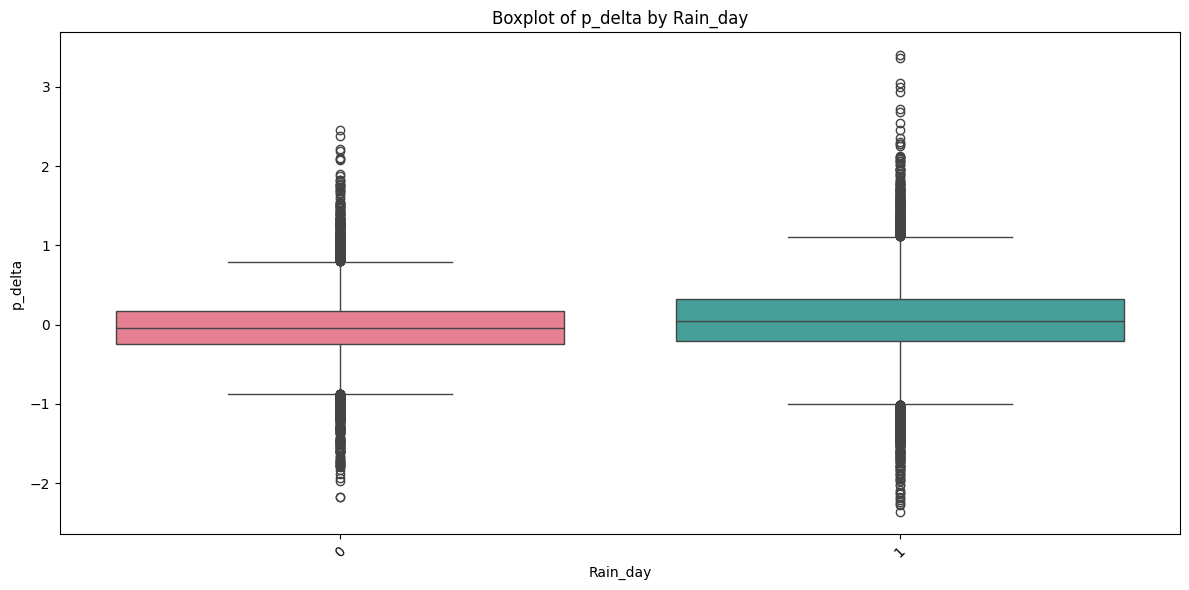

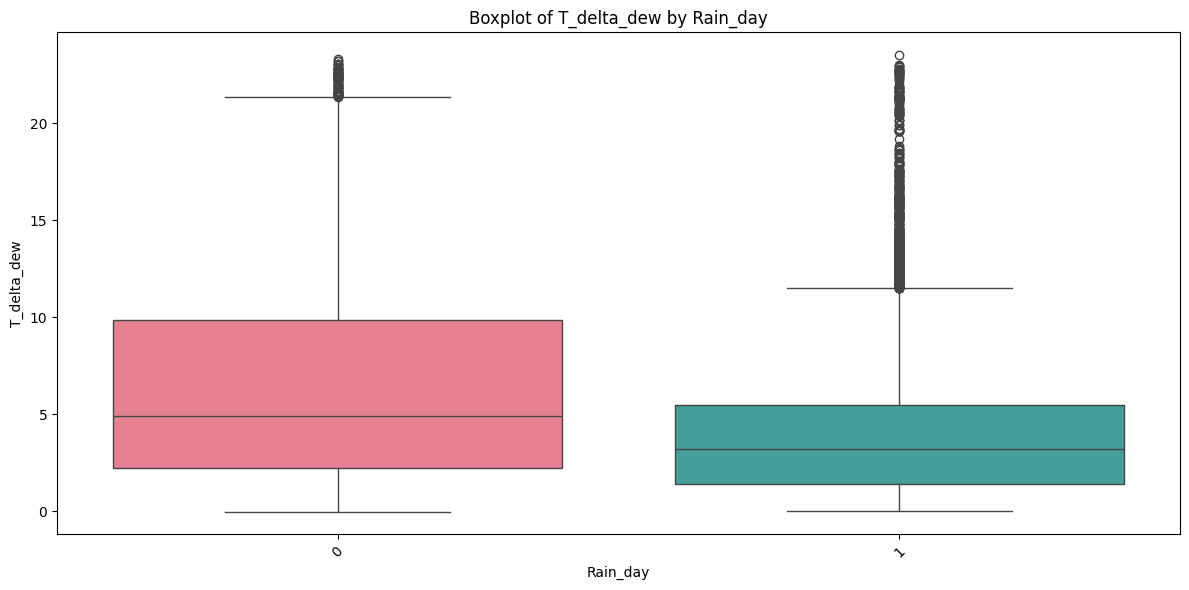

In [11]:
# Pressure on rainy vs non-rainy days
utils._plot_boxplot(raw, "p", "rain_day")

# Temperature on rainy vs non-rainy days
utils._plot_boxplot(raw, "T", "rain_day")

# Relative humidity on rainy vs non-rainy days
utils._plot_boxplot(raw, "rh", "rain_day")

# Pressure change on rainy vs non-rainy days
utils._plot_boxplot(raw, "p_delta", "rain_day")

# Temperature-dew point difference on rainy vs non-rainy days
utils._plot_boxplot(raw, "T_delta_dew", "rain_day")

## 7. Solar Radiation and Weather Type Analysis

Analyze the relationship between solar radiation and rainfall patterns.

### 7.1 Rainfall Distribution by Solar Radiation Categories

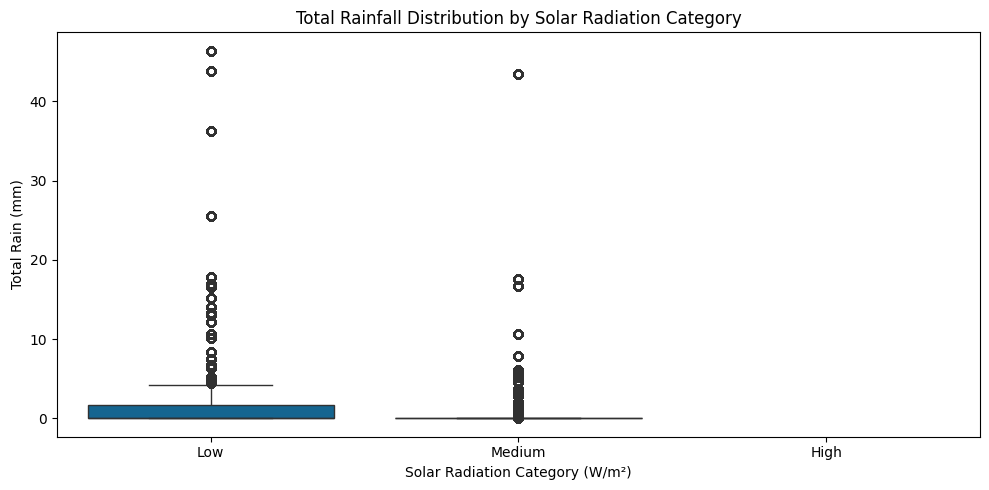

In [12]:
# Create a copy for analysis
df = raw.copy()

# Define solar radiation bins
bins = [0, 100, 600, 1000]
labels = ['Low', 'Medium', 'High']

# Create analysis dataframe
df_plot = (
    df.loc[:, ['SWDR_mean', 'rain_total']].copy()
      .reset_index(drop=True)
      .assign(SWDR_cat=pd.cut(df['SWDR_mean'].to_numpy(), bins=bins, labels=labels))
      .dropna(subset=['SWDR_cat', 'rain_total'])
)

# Create box plot
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_plot, x='SWDR_cat', y='rain_total', order=labels)
plt.title('Total Rainfall Distribution by Solar Radiation Category')
plt.xlabel('Solar Radiation Category (W/m²)')
plt.ylabel('Total Rain (mm)')
plt.tight_layout()
plt.show()

### 7.2 Daylight Hours Analysis

Filter and analyze data during daylight hours when solar radiation is significant:

In [13]:
# Filter for daylight hours (when solar radiation > 10 and PAR > 5)
df_daylight = df[(df['SWDR'] > 10) & (df['PAR'] > 5)]

print(f"Total observations: {len(df):,}")
print(f"Daylight observations: {len(df_daylight):,}")
print(f"Percentage of daylight hours: {len(df_daylight)/len(df)*100:.1f}%")

# Show basic statistics for daylight hours
daylight_stats = df_daylight[['SWDR', 'PAR', 'T', 'rh', 'rain']].describe()
display(daylight_stats)

Total observations: 52,696
Daylight observations: 25,032
Percentage of daylight hours: 47.5%


,SWDR,PAR,T,rh,rain
count,25032.000000,25032.000000,25032.000000,25032.000000,25032.000000
mean,276.097558,545.846702,13.482218,64.826177,0.011521
std,240.945941,469.557281,7.581937,20.036246,0.125585
min,10.030000,14.660000,-6.340000,21.160000,0.000000
25%,75.065000,156.835000,7.470000,47.790000,0.000000
50%,199.150000,397.015000,13.500000,65.480000,0.000000
75%,425.150000,832.097500,19.320000,80.900000,0.000000
max,1115.290000,2131.760000,34.800000,100.000000,11.200000


### 7.3 Weather Type Classification

Create weather type categories based on solar radiation and other variables:

In [ ]:
# Create daily aggregations for classification
daily = df_daylight.groupby(df_daylight.index.date).agg({
    'SWDR': ['mean', 'max'],
    'PAR': ['mean', 'max'],
    'rain': 'sum',
    'T': 'mean',
    'rh': 'mean',
    'p': 'mean'
})

# Flatten column names
daily.columns = ['_'.join(col).strip() for col in daily.columns.values]

# Define weather type classification function
def classify_day(row):
    if row['SWDR_max'] < 50 and row['PAR_max'] < 50:
        return 'Night/No Sun'
    elif row['SWDR_mean'] > 250 and row['PAR_mean'] > 1000:
        return 'Sunny'
    elif row['SWDR_mean'] > 100 and row['PAR_mean'] > 400:
        return 'Partly Cloudy'
    else:
        return 'Overcast'

# Apply classification
daily['day_type'] = daily.apply(classify_day, axis=1)

# Show weather type distribution
print("Weather Type Distribution:")
print(daily['day_type'].value_counts())

# Show average weather conditions by type
weather_summary = daily.groupby('day_type')[['SWDR_mean', 'PAR_mean', 'rain_sum', 'T_mean', 'rh_mean']].mean()
display(weather_summary)

Weather Type Distribution:
day_type
Partly Cloudy    185
Overcast         175
Sunny              6
Name: count, dtype: int64


,SWDR_mean,PAR_mean,rain_sum,T_mean,rh_mean
day_type,,,,,
Overcast,120.930840,243.004785,1.213714,7.645591,79.086251
Partly Cloudy,359.487434,706.349564,0.410811,16.192818,56.739080
Sunny,516.576063,1021.881223,0.000000,18.562760,44.985869


## 7. Key Findings and Insights

### Key Observations from Data Analysis:

**Temporal Patterns:**
- Clear daily cycles in temperature and solar radiation
- Seasonal patterns visible in temperature and humidity
- Strong correlation between temperature and solar radiation

**Weather Relationships:**
- Inverse relationship between humidity and temperature
- Lower pressure often associated with rainy days
- Wind speed categories show different temperature distributions

**Weather Type Analysis:**
- Successfully identified distinct weather patterns through clustering
- Solar radiation strongly influences weather type classification
- Rain patterns correlate with solar radiation levels

**Feature Engineering Results:**
- Created meaningful daily aggregations and cyclical features
- Delta features capture important weather changes
- Wind categorization provides useful groupings

### Implications for Forecasting:

1. **Multi-variable Dependencies**: Weather variables are highly interconnected
2. **Temporal Patterns**: Clear daily and seasonal cycles should be captured
3. **Weather States**: Distinct weather types suggest regime-based modeling
4. **Change Indicators**: Delta features may be powerful predictors

### Next Steps:

1. **Advanced Feature Engineering**: Create lag features and rolling statistics
2. **Seasonal Decomposition**: Separate trend, seasonal, and residual components
3. **Model Development**: Implement time series forecasting models
4. **Model Validation**: Set up proper evaluation framework

---

*This completes the comprehensive data analysis phase. The insights gained will guide our modeling approach in subsequent notebooks.*